Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Kats Outliers Detection

* Kats General
  * `TimeSeriesData` params and methods: https://facebookresearch.github.io/Kats/api/kats.consts.html#kats.consts.TimeSeriesData
* Kats Detection
  * Kats detection official tutorial: https://github.com/facebookresearch/Kats/blob/main/tutorials/kats_202_detection.ipynb
    * It describes Kats' outlier detector's algorithms
    * But Kats' multivariate anomaly detection only output strange errors to me, even using the same tutorial code, see this ticket: https://github.com/facebookresearch/Kats/issues/194
* Other Kats Outlier Detectors
  * https://facebookresearch.github.io/Kats/api/kats.detectors.prophet_detector.html
    * Kats v0.1 requires prophet version to be "0.7" exactly, other will get errors, but my laptop could only install higher version prophet...
  * https://facebookresearch.github.io/Kats/api/kats.detectors.hourly_ratio_detection.html
    * It requires the time series to be hour-level granularity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM

from kats.consts import TimeSeriesData
from kats.detectors.outlier import OutlierDetector

import warnings
warnings.filterwarnings("ignore")

In [2]:
ts_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/sales_ts.pkl')
print(ts_df.shape)

ts_df_train = ts_df.iloc[ts_df.index < '2015-03-01']
print(ts_df_train.shape)

ts_df.head()

(942, 1)
(789, 1)


,Daily_Sales
Date,
2013-01-01,58165
2013-01-02,4822042
2013-01-03,4415571
2013-01-04,4587035
2013-01-05,4078281


In [3]:
def plot_ts(ts, title):
    plt.figure(figsize=(20,3))
    for col in ts.columns:
        fig = plt.plot(ts[col], label=col)
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

def plot_ts_outliers(ts, title, outliers, decomp='additive'):
    outliers_x = [str(outlier).split()[0] for outlier in outliers[0]]
    outliers_y = ts.iloc[ts.index.isin(outliers_x)]
    
    plt.figure(figsize=(20,10))
    plt.subplot(411)
    fig = plt.plot(ts, label='original ts', color='blue')
    plt.scatter(outliers_x, outliers_y, c='red', marker='*')
    plt.legend(loc='best')
    
    plt.subplot(412)
    decomposition = seasonal_decompose(ts, model=decomp)
    residual = decomposition.resid
    fig = plt.plot(residual, label='residuals', color='purple')
    outliers_y_res = residual.iloc[residual.index.isin(outliers_x)]
    plt.scatter(outliers_x, outliers_y_res, c='red', marker='*')
    plt.legend(loc='best')
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

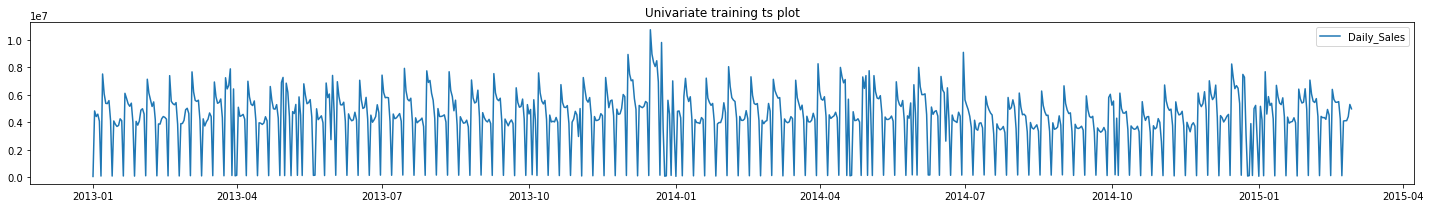

In [4]:
plot_ts(ts_df_train, title='Univariate training ts plot')

In [5]:
# Covert to Kats required TimeSeriesData input

kats_ts_all = TimeSeriesData(ts_df_train.reset_index().rename(index=str, columns={'Date': 'time'}))
print(len(kats_ts_all))

789


## Univariate OutlierDetector

* Kats' outlier detector: https://facebookresearch.github.io/Kats/api/kats.detectors.outlier.html

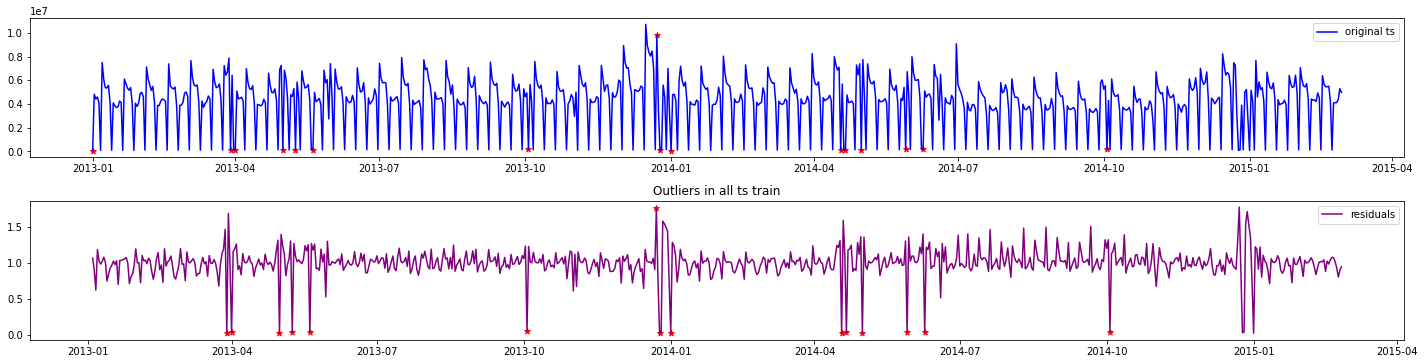

In [6]:
# detect & plot outliers

ts_outlierDetection = OutlierDetector(kats_ts_all, 'multiplication', iqr_mult=5)
ts_outlierDetection.detector()

plot_ts_outliers(ts_df_train, title='Outliers in all ts train', outliers=ts_outlierDetection.outliers, decomp='multiplicative')

In [42]:
# remove and plot outliers

ts_outlierDetection_outliers_removed = ts_outlierDetection.remover(interpolate = False) # No interpolation
ts_outlierDetection_interpolated = ts_outlierDetection.remover(interpolate = True) # With linear interpolation

ts_outlierDetection_outliers_removed

,time,y_0
0,2013-01-01,NaN
1,2013-01-02,4822042.0
2,2013-01-03,4415571.0
3,2013-01-04,4587035.0
4,2013-01-05,4078281.0
...,...,...
784,2015-02-24,4110170.0
785,2015-02-25,4116290.0
786,2015-02-26,4407945.0
787,2015-02-27,5293697.0


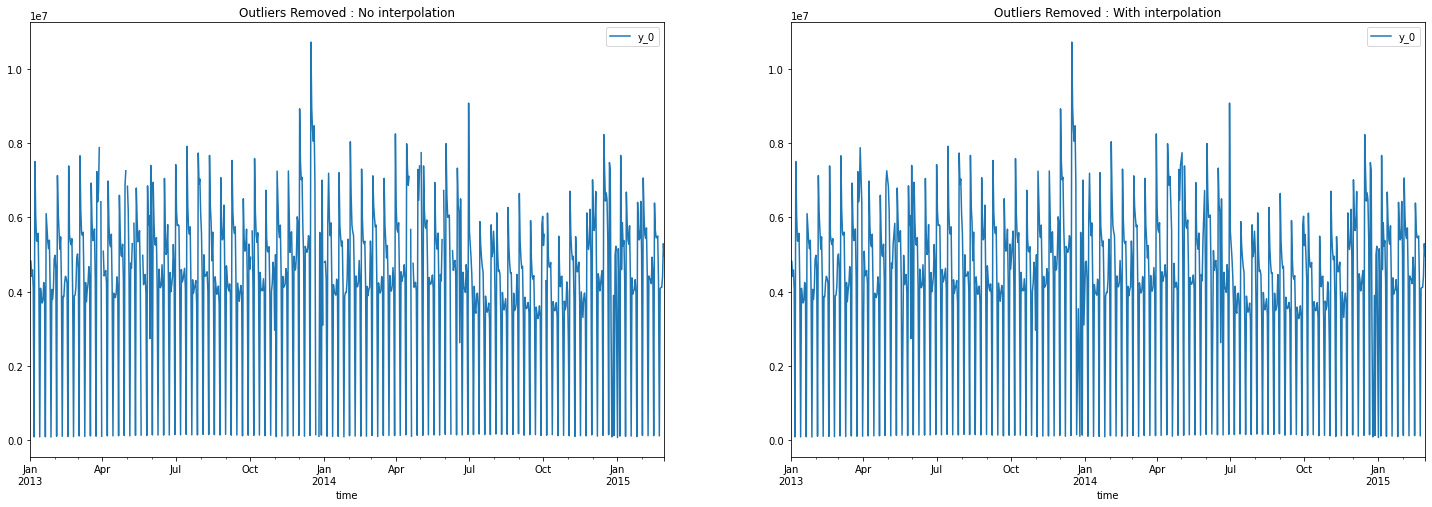

In [44]:
fig, ax = plt.subplots(figsize=(25,8), nrows=1, ncols=2)
ts_outlierDetection_outliers_removed.to_dataframe().plot(x='time',y = 'y_0', ax = ax[0])
ax[0].set_title("Outliers Removed : No interpolation")
ts_outlierDetection_interpolated.to_dataframe().plot(x = 'time',y = 'y_0', ax = ax[1])
ax[1].set_title("Outliers Removed : With interpolation")
plt.show()

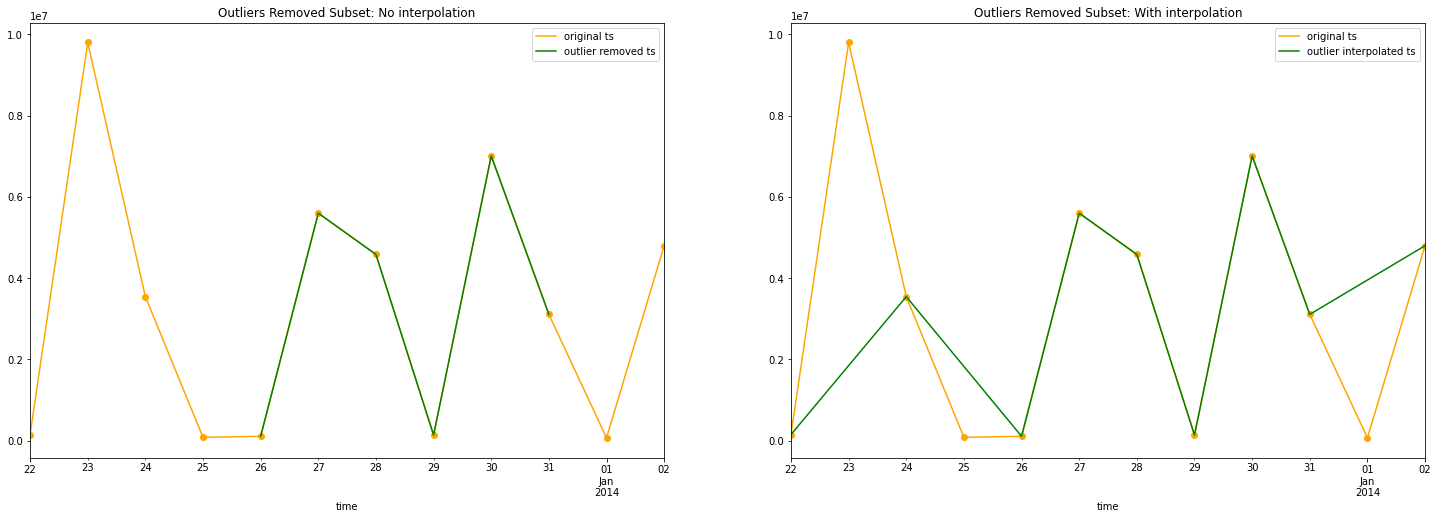

In [79]:
sub_original_df = ts_df_train.iloc[(ts_df_train.index>='2013-12-22') & (ts_df_train.index<='2014-01-02')]
sub_df_removed = ts_outlierDetection_outliers_removed.to_dataframe()
sub_df_removed = sub_df_removed.loc[(sub_df_removed['time']>='2013-12-22') & (sub_df_removed['time']<='2014-01-02')]

sub_df_interpolated = ts_outlierDetection_interpolated.to_dataframe()
sub_df_interpolated = sub_df_interpolated.loc[(sub_df_interpolated['time']>='2013-12-22') & (sub_df_interpolated['time']<='2014-01-02')]

fig, ax = plt.subplots(figsize=(25,8), nrows=1, ncols=2)
sub_original_df.reset_index().plot(x='Date', y='Daily_Sales', ax=ax[0], color='orange', marker='o', label='original ts')
sub_df_removed.plot(x='time', y='y_0', ax= ax[0], color='green', label='outlier removed ts')
ax[0].set_title("Outliers Removed Subset: No interpolation")

sub_original_df.reset_index().plot(x='Date', y='Daily_Sales', ax=ax[1], color='orange', marker='o', label='original ts')
sub_df_interpolated.plot(x = 'time',y = 'y_0', ax= ax[1], color='green', label='outlier interpolated ts')
ax[1].set_title("Outliers Removed Subset: With interpolation")
plt.show()

## Multivariate Anomaly Detection

* References
  * VAR for anomaly detection: https://www.analyticsvidhya.com/blog/2021/08/multivariate-time-series-anomaly-detection-using-var-model/
  * More about VAR: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
* More multivariate time series models: https://www.statsmodels.org/dev/api.html#multivariate-time-series-models

In [9]:
mul_ts_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/multivar_ts.pkl')

print(mul_ts_df.shape)
mul_ts_df.head()

(8143, 6)


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [10]:
occupancy = mul_ts_df[['Occupancy']]
mul_ts_df.drop('Occupancy', inplace=True, axis=1)
print(mul_ts_df.shape)

(8143, 5)


### Convert Data to Stationary

In [5]:
def test_stationarity_multi_ts(multi_ts_df):
    results_dct = {}
    
    for col in multi_ts_df.columns:
        timeseries = multi_ts_df[col]
        
        adf_result, kpss_result = None, None
        results_dct[col] = {'Differencing Stationary': None, 'Trending Stationary': None}
    
        # Perform Augmented Dickey-Fuller test:
        adftest = adfuller(timeseries, autolag='AIC')
        adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        adf_test_stats = adf_output['Test Statistic']
        for key,value in adftest[4].items():
            adf_output[f'Critical Value {key}'] = value
            
        if abs(adf_test_stats) >= abs(adf_output[f'Critical Value 1%']):
            adf_result = '99%'
        elif abs(adf_test_stats) >= abs(adf_output[f'Critical Value 5%']) and abs(adf_test_stats) < abs(adf_output[f'Critical Value 1%']):
            adf_result = '95%'
        elif abs(adf_test_stats) >= abs(adf_output[f'Critical Value 10%']) and abs(adf_test_stats) < abs(adf_output[f'Critical Value 5%']):
            adf_result = '90%'

            
        # Perform KPSS
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        kpss_test_stats = kpss_output['Test Statistic']
        for key,value in kpsstest[3].items():
            kpss_output[f'Critical Value {key}'] = value

        if abs(kpss_test_stats) >= abs(kpss_output['Critical Value 1%']):
            kpss_result = '99%'
        elif abs(kpss_test_stats) >= abs(kpss_output['Critical Value 2.5%']) and abs(kpss_test_stats) < abs(kpss_output[f'Critical Value 1%']):
            kpss_result = '97.5%'
        elif abs(kpss_test_stats) >= abs(kpss_output['Critical Value 5%']) and abs(kpss_test_stats) < abs(kpss_output[f'Critical Value 2.5%']):
            kpss_result = '95%'
        elif abs(kpss_test_stats) >= abs(kpss_output['Critical Value 10%']) and abs(kpss_test_stats) < abs(kpss_output[f'Critical Value 5%']):
            kpss_result = '90%'
    
        results_dct[col]['Differencing Stationary'] = adf_result
        results_dct[col]['Trending Stationary'] = kpss_result
        
    return results_dct


def detect_anomalies(squared_errors, n=1):
    threshold = np.mean(squared_errors) + n*np.std(squared_errors)
    detections = (squared_errors >= threshold).astype(int)
    
    return threshold, detections

In [6]:
mul_ts_df['Humidity'] = mul_ts_df['Humidity'].diff()
mul_ts_df['HumidityRatio'] = mul_ts_df['HumidityRatio'].diff()
mul_ts_df = mul_ts_df.dropna()
print(mul_ts_df.shape)

multi_ts_stationary = test_stationarity_multi_ts(mul_ts_df)
for k, v in multi_ts_stationary.items():
    print(k)
    print(v)
    print()

(8142, 5)
Temperature
{'Differencing Stationary': '90%', 'Trending Stationary': '99%'}

Humidity
{'Differencing Stationary': '99%', 'Trending Stationary': '97.5%'}

Light
{'Differencing Stationary': '95%', 'Trending Stationary': '99%'}

CO2
{'Differencing Stationary': '99%', 'Trending Stationary': '99%'}

HumidityRatio
{'Differencing Stationary': '99%', 'Trending Stationary': '97.5%'}



### VAR to Detect Anomalies

* The way it detects anomalies is to find observations with residuals above a threshold

In [8]:
# select better model order
max_lag = 20
var_model = VAR(mul_ts_df)
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(f'Selected VAR order is {selected_lag}')

lag_results.summary()

Selected VAR order is 18


,AIC,BIC,FPE,HQIC
0,-8.116,-8.112,0.0002987,-8.115
1,-27.71,-27.69,9.219e-13,-27.70
2,-28.04,-27.99,6.646e-13,-28.02
3,-28.12,-28.05,6.118e-13,-28.10
4,-28.18,-28.09,5.765e-13,-28.15
5,-28.23,-28.12,5.471e-13,-28.20
6,-28.30,-28.16,5.143e-13,-28.25
7,-28.35,-28.20*,4.858e-13,-28.30
8,-28.37,-28.20,4.767e-13,-28.31
9,-28.39,-28.19,4.675e-13,-28.32


In [9]:
model_fitted = var_model.fit(selected_lag)

# durbin_watson test to check whether there is any leftover pattern in the residuals, closer to 2, the better
dw_scores = durbin_watson(model_fitted.resid)

for col, dw in zip(mul_ts_df.columns, dw_scores):
    print(f'{col}: {dw}')

Temperature: 1.9999348527449858
Humidity: 2.0005990988062603
Light: 2.001429820977524
CO2: 2.0001469651272985
HumidityRatio: 2.0004844080080337


In [10]:
model_fitted.resid

,Temperature,Humidity,Light,CO2,HumidityRatio
date,,,,,
2015-02-04 18:10:00,-0.026796,0.067853,-40.903028,7.162527,0.000003
2015-02-04 18:10:59,0.026333,0.015115,-7.453054,5.290719,0.000009
2015-02-04 18:11:59,0.029284,0.026413,-19.610163,4.934303,0.000012
2015-02-04 18:13:00,0.033011,0.050597,9.604023,5.577027,0.000017
2015-02-04 18:14:00,0.041898,0.062271,-26.044094,2.093218,0.000023
...,...,...,...,...,...
2015-02-10 09:29:00,0.004687,0.040900,-2.803833,4.091280,0.000008
2015-02-10 09:29:59,-0.011261,-0.129102,0.484127,-7.296797,-0.000024
2015-02-10 09:30:59,0.036916,0.018238,1.887318,3.303214,0.000016


In [11]:
squared_errors = model_fitted.resid.sum(axis=1)**2

threshold, detections = detect_anomalies(squared_errors, n=1)
detected_mul_ts_df = mul_ts_df.copy()
detected_mul_ts_df['anomaly_detection'] = detections
detected_mul_ts_df['Occupancy'] = occupancy
detected_mul_ts_df = detected_mul_ts_df.iloc[selected_lag:, :]
print(f'Threshold: {threshold}')

detected_mul_ts_df.head()

Threshold: 11333.96059868146


,Temperature,Humidity,Light,CO2,HumidityRatio,anomaly_detection,Occupancy
date,,,,,,,
2015-02-04 18:10:00,22.89,0.000,0.0,689.0,-0.000016,0.0,0
2015-02-04 18:10:59,22.89,0.000,0.0,689.5,0.000000,0.0,0
2015-02-04 18:11:59,22.89,0.000,0.0,689.0,0.000000,0.0,0
2015-02-04 18:13:00,22.89,0.055,0.0,691.0,0.000010,0.0,0
2015-02-04 18:14:00,22.89,0.055,0.0,688.0,0.000010,0.0,0


In [12]:
detected_mul_ts_df.loc[detected_mul_ts_df['anomaly_detection']==1].head()

,Temperature,Humidity,Light,CO2,HumidityRatio,anomaly_detection,Occupancy
date,,,,,,,
2015-02-05 07:38:00,20.700000,0.000000,356.000000,457.000000,0.000000,1.0,1
2015-02-05 12:19:00,22.426667,0.027500,744.000000,1098.333333,0.000015,1.0,1
2015-02-05 12:23:59,22.600000,0.025000,558.000000,1102.000000,0.000004,1.0,1
2015-02-05 12:24:59,22.600000,0.041667,661.333333,1105.000000,0.000007,1.0,1
2015-02-05 12:58:00,22.890000,-0.078333,567.250000,1020.000000,-0.000004,1.0,0


In [13]:
# Check whether there's any anomaly pattern in different occupancy
no_occpupancy_df = detected_mul_ts_df.loc[detected_mul_ts_df['Occupancy']==0]
has_occpupancy_df = detected_mul_ts_df.loc[detected_mul_ts_df['Occupancy']==1]

print(no_occpupancy_df['anomaly_detection'].value_counts()/len(no_occpupancy_df))
print()
print(has_occpupancy_df['anomaly_detection'].value_counts()/len(has_occpupancy_df))

0.0    0.995321
1.0    0.004679
Name: anomaly_detection, dtype: float64

0.0    0.991243
1.0    0.008757
Name: anomaly_detection, dtype: float64


### VECM to Detect Anomalies

* About VECM: https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.vecm.VECM.html#statsmodels.tsa.vector_ar.vecm.VECM

In [14]:
k_ar_diff = 18
vecm_model = VECM(mul_ts_df, k_ar_diff=k_ar_diff)
vecm_model_fitted = vecm_model.fit()

In [15]:
vecm_dw_scores = durbin_watson(vecm_model_fitted.resid)

for col, dw in zip(mul_ts_df.columns, vecm_dw_scores):
    print(f'{col}: {dw}')

Temperature: 2.0003353804623627
Humidity: 2.0001296254440404
Light: 2.0001636903225966
CO2: 2.0004122200313583
HumidityRatio: 2.0004128612279386


In [16]:
vecm_squared_errors = vecm_model_fitted.resid.sum(axis=1)**2

vecm_threshold, vecm_detections = detect_anomalies(vecm_squared_errors, n=1)
vecm_detected_mul_ts_df = mul_ts_df.iloc[k_ar_diff+1:, :]
vecm_detected_mul_ts_df['anomaly_detection'] = vecm_detections

print(f'Threshold: {threshold}')

vecm_detected_mul_ts_df.head()

Threshold: 11333.96059868146


,Temperature,Humidity,Light,CO2,HumidityRatio,anomaly_detection
date,,,,,,
2015-02-04 18:10:59,22.89,0.000,0.0,689.5,0.00000,0
2015-02-04 18:11:59,22.89,0.000,0.0,689.0,0.00000,0
2015-02-04 18:13:00,22.89,0.055,0.0,691.0,0.00001,0
2015-02-04 18:14:00,22.89,0.055,0.0,688.0,0.00001,0
2015-02-04 18:15:00,22.89,0.000,0.0,689.5,0.00000,0


In [39]:
compare_df = pd.merge(vecm_detected_mul_ts_df[['anomaly_detection']], detected_mul_ts_df[['anomaly_detection']], left_index=True, right_index=True)
print(len(compare_df))

compare_df.head()

8123


,anomaly_detection_x,anomaly_detection_y
date,,
2015-02-04 18:10:59,0,0.0
2015-02-04 18:11:59,0,0.0
2015-02-04 18:13:00,0,0.0
2015-02-04 18:14:00,0,0.0
2015-02-04 18:15:00,0,0.0


In [44]:
compare_df.loc[(compare_df['anomaly_detection_x'] != compare_df['anomaly_detection_y'])]

,anomaly_detection_x,anomaly_detection_y
date,,
2015-02-06 12:53:00,1,0.0
2015-02-06 13:18:00,0,1.0
